In [45]:
from sklearn import linear_model
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

In [46]:
"""
Ingest XLS data into dataframes to train and test on
"""
def load_data(filepath, target_column):
    df = pd.read_csv(filepath)
    
    X = df.drop(columns=[target_column])
    y = df[target_column]
    
    return X, y

train_filepath = "/Users/ethanmcaleavy/Documents/CompSci /CSCI 4622/Project/CSCI4622_project_lashley_lads/data_for_KNN_train.csv"
test_filepath = "/Users/ethanmcaleavy/Documents/CompSci /CSCI 4622/Project/CSCI4622_project_lashley_lads/data_for_KNN_test.csv"    
target_column = "log_price" 

X_train, y_train = load_data(train_filepath, target_column)
X_test, y_test = load_data(test_filepath, target_column)


In [47]:
class Lasso(object):
    def __init__(self, alpha, normalize=False):
        self.alpha = alpha
        self.coefficients = None
        self.intercept = None
        self.normalize = normalize
        self.scaler = StandardScaler()
        self.model = linear_model.Lasso(alpha=alpha, fit_intercept=True)

    def fit(self, X, y):
        num_nonzero_coefs, coefs_norm = 0, 0
        if self.normalize: 
            X = self.scaler.fit_transform(X)

        self.model.fit(X, y)
        self.intercept = self.model.intercept_
        self.coefficients = self.model.coef_

        num_nonzero_coefs = np.sum(self.coefficients != 0)
        coefs_norm = np.linalg.norm(self.coefficients)
            
        return num_nonzero_coefs, coefs_norm

    def evaluate(self, X, y):
        root_mean_squared_error = 0
        if self.normalize:
            X = self.scaler.transform(X)

        pred = X.dot(self.coefficients) + self.intercept
        
        root_mean_squared_error = np.sqrt(np.mean((pred - y) ** 2))

        return root_mean_squared_error

/Users/ethanmcaleavy/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.718e+02, tolerance: 5.436e-01
  model = cd_fast.enet_coordinate_descent(
/Users/ethanmcaleavy/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.086e-01, tolerance: 5.436e-01
  model = cd_fast.enet_coordinate_descent(


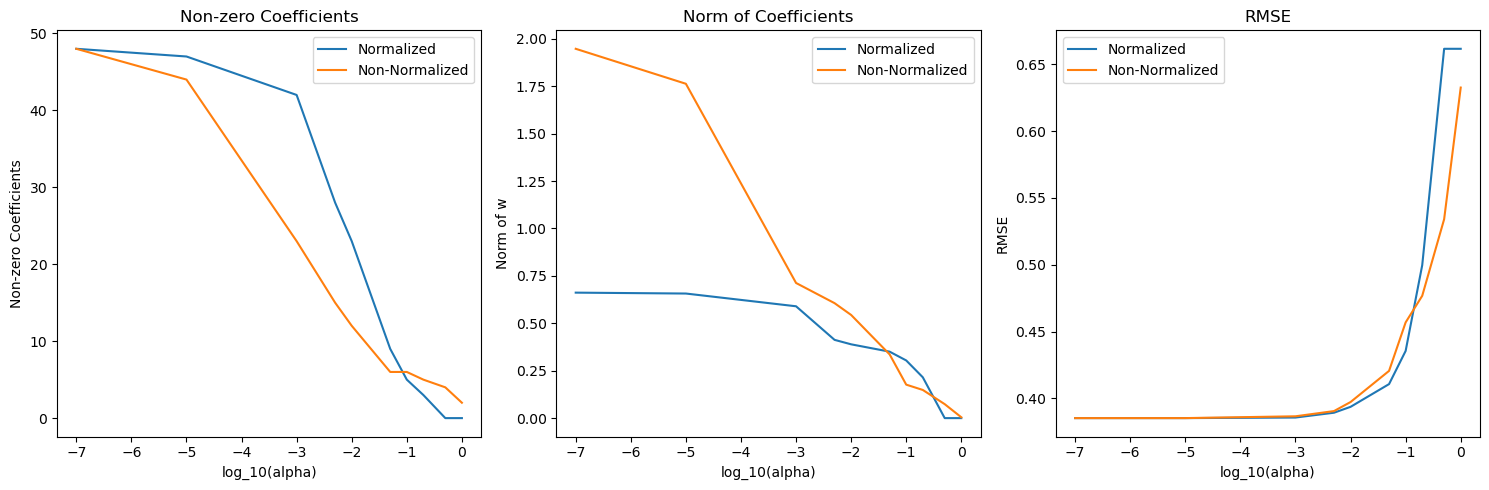

Minimum error non_normalized for alpha 1e-07: 0.38524058512215587
Minimum error normalized for alpha 1e-07: 0.38524071449171543


In [52]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

X_train = X_train.fillna(0.5)
X_test = X_test.fillna(0.5)

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

alphas = [1e-7, 1e-5, 1e-3, 5e-3, 0.01, 0.05, 0.1, 0.2, 0.5, 1]
non_zeros = []
norms = []
RMSE = []

non_zeros_normalized = []
norms_normalized = []
RMSE_normalized = []


best_alpha_norm = 0
best_alpha_nonNorm = 0
unormalized_min_rmse = np.inf
normalized_min_rmse = np.inf

for alpha in alphas:

    Ridge_object = Lasso(alpha=alpha, normalize = False)
    nonZero, norm = Ridge_object.fit(X_train,y_train)
    rmse = Ridge_object.evaluate(X_test,y_test)

    non_zeros.append(nonZero)
    norms.append(norm)
    RMSE.append(rmse)

    if rmse < unormalized_min_rmse:
        unormalized_min_rmse = rmse
        best_alpha_nonNorm = alpha

    Ridge_object_normalized = Lasso(alpha=alpha, normalize = True)
    nonZeroNormalized, normNormalized = Ridge_object_normalized.fit(X_train,y_train)
    rmseNormalized = Ridge_object_normalized.evaluate(X_test,y_test)

    non_zeros_normalized.append(nonZeroNormalized)
    norms_normalized.append(normNormalized)
    RMSE_normalized.append(rmseNormalized)

    if rmseNormalized < normalized_min_rmse:
        normalized_min_rmse = rmseNormalized
        best_alpha_Norm = alpha

    

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
log_alphas = np.log10(alphas)

ax1.plot(log_alphas, non_zeros_normalized, label="Normalized")
ax1.plot(log_alphas, non_zeros, label="Non-Normalized")
ax1.set_title('Non-zero Coefficients')
ax1.set_xlabel('log_10(alpha)')
ax1.set_ylabel('Non-zero Coefficients')
ax1.legend()

ax2.plot(log_alphas, norms_normalized, label="Normalized")
ax2.plot(log_alphas, norms, label="Non-Normalized")
ax2.set_title('Norm of Coefficients')
ax2.set_xlabel('log_10(alpha)')
ax2.set_ylabel('Norm of w')
ax2.legend()

ax3.plot(log_alphas, RMSE_normalized, label="Normalized")
ax3.plot(log_alphas, RMSE, label="Non-Normalized")
ax3.set_title('RMSE')
ax3.set_xlabel('log_10(alpha)')
ax3.set_ylabel('RMSE')
ax3.legend()

plt.tight_layout()
plt.show()

print(f"Minimum error non_normalized for alpha {best_alpha_nonNorm}: {unormalized_min_rmse}")
print(f"Minimum error normalized for alpha {best_alpha_Norm}: {normalized_min_rmse}")


In [56]:
# Lets try a more straight forward approach:

import numpy as np
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

def load_data(filepath, target_column):
    df = pd.read_csv(filepath)
    
    X = df.drop(columns=[target_column])
    y = df[target_column]
    
    return X, y

train_filepath = "/Users/ethanmcaleavy/Documents/CompSci /CSCI 4622/Project/CSCI4622_project_lashley_lads/data_for_KNN_train.csv"
test_filepath = "/Users/ethanmcaleavy/Documents/CompSci /CSCI 4622/Project/CSCI4622_project_lashley_lads/data_for_KNN_test.csv"    
target_column = "log_price" 

X_train, y_train = load_data(train_filepath, target_column)
X_test, y_test = load_data(test_filepath, target_column)

In [57]:
scaler = StandardScaler()

X_train = X_train.fillna(0.5)
X_test = X_test.fillna(0.5)

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


lasso = Lasso(alpha=0.1) 
lasso.fit(X_train, y_train)

# Predict using the test data
y_pred = lasso.predict(X_test)

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f'RMSE: {rmse}')

RMSE: 0.4568665166161784
